In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import pandas as pd
from kloppy import secondspectrum


In [3]:
import sys
 
# setting path
sys.path.append('../')
 
# # importing
from src.second_spectrum_utils import get_home_away_tracking
import src.player_velocities as vel
import src.pitch_control as pc
import src.visualizations as viz

In [4]:
dataset = secondspectrum.load(
    meta_data="../man-city-data/SecondSpectrum/MCI Women_s Files-001/g2312135_SecondSpectrum_meta.xml",
    raw_data="../man-city-data/SecondSpectrum/MCI Women_s Files-001/g2312135_SecondSpectrum_tracking-produced.jsonl",
    
    # Optional arguments
    sample_rate=1/1,
    coordinates="secondspectrum",
    only_alive=False)


In [5]:
home_df, away_df = get_home_away_tracking(dataset)

In [6]:
tracking_home = vel.calc_player_velocities(home_df,smoothing=True,filter_='moving_average')
tracking_away = vel.calc_player_velocities(away_df,smoothing=True,filter_='moving_average')

In [7]:
params=pc.parameters()

In [8]:
df = dataset.to_df()

In [89]:
frame = 14875
attacking_team = df.loc[df.frame_id == frame, "ball_owning_team_id"].item().capitalize()
attacking_team

'Away'

(<Figure size 1200x800 with 2 Axes>, <Axes: >)

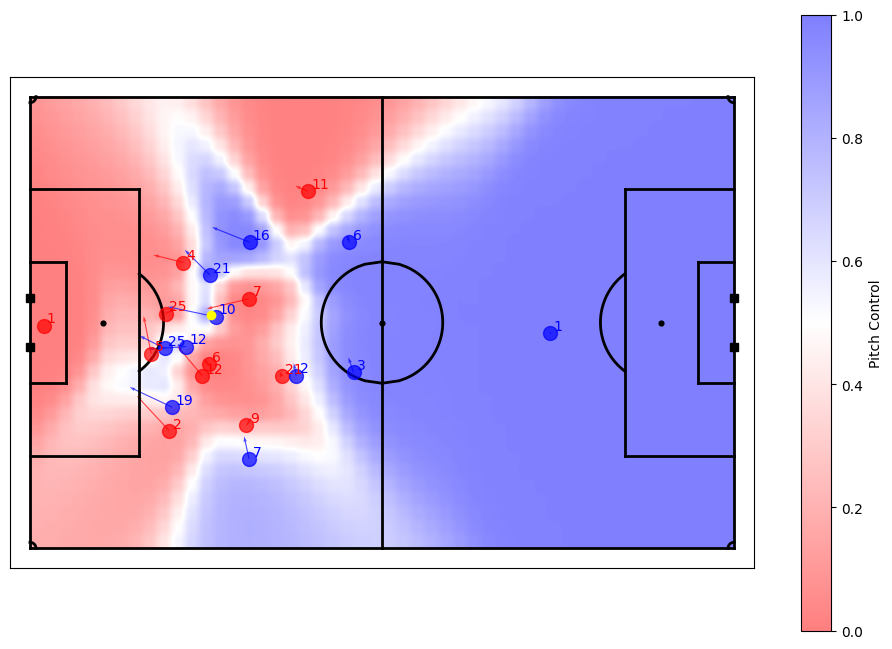

In [90]:
viz.plot_pitch_control_for_frame(frame, tracking_home, tracking_away, attacking_team, params)

off ball expected threat: 1.4%


(<Figure size 1200x800 with 1 Axes>, <Axes: >)

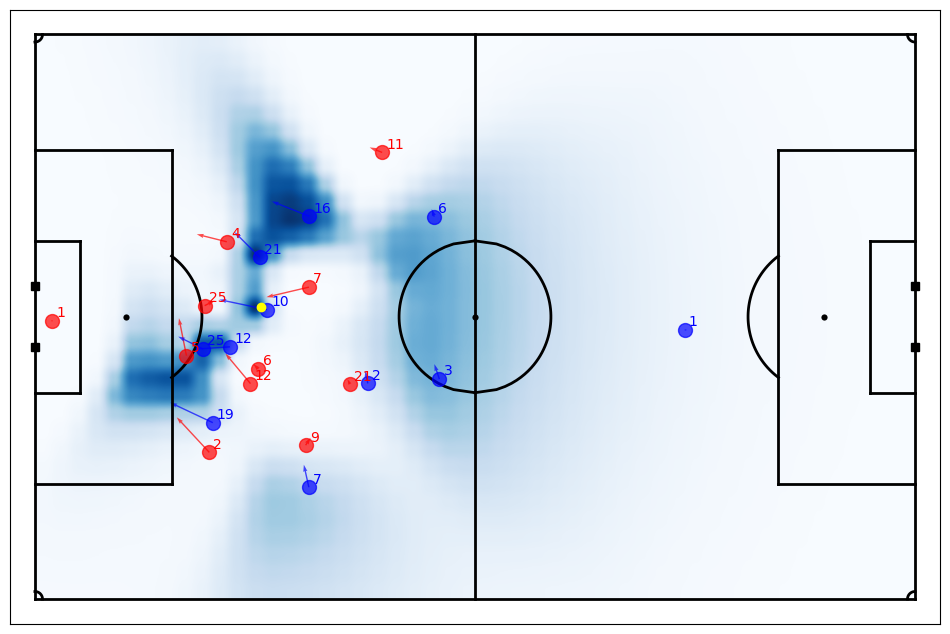

In [91]:
plot_scoring_opp_for_frame(frame, tracking_home, tracking_away, attacking_team, params)

(<Figure size 1200x800 with 2 Axes>, <Axes: >)

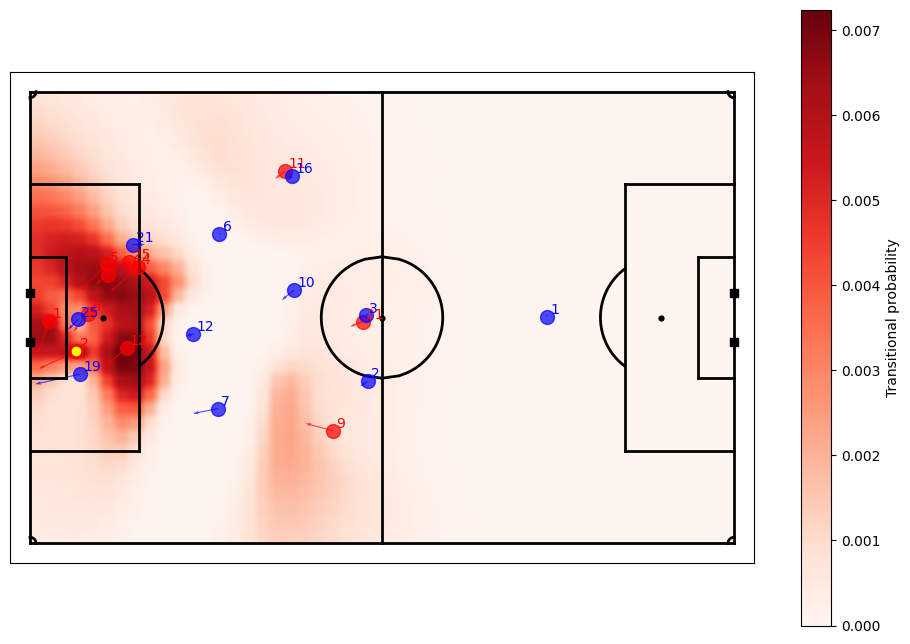

In [63]:
viz.plot_transition_proba_for_frame(frame, tracking_home, tracking_away, attacking_team,params)

(<Figure size 1200x800 with 2 Axes>, <Axes: >)

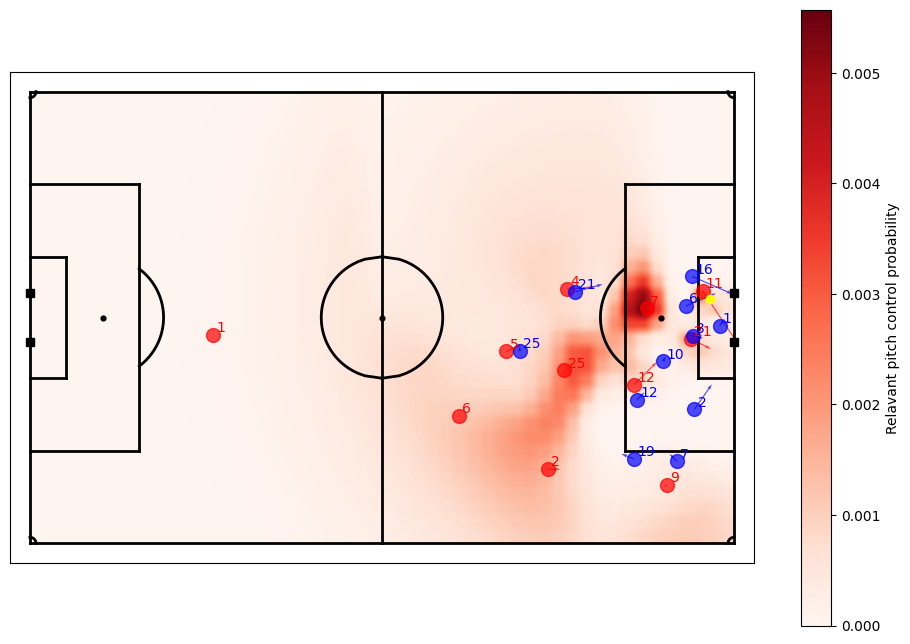

In [53]:
viz.plot_relevant_pitch_for_frame(frame, tracking_home, tracking_away, attacking_team ,params)

In [54]:
import socceraction.xthreat as xthreat
# Load the xT model in

def generate_expected_threat_surface(where_attack, field_dimen=(106.,68.), n_grid_cells_x = 100):
    
    url_grid = "https://karun.in/blog/data/open_xt_12x8_v1.json"
    xT_model = xthreat.load_model(url_grid)
    # break the pitch down into a grid
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    interp = xT_model.interpolator()
    xgrid = np.linspace(0, 105, n_grid_cells_x)
    ygrid = np.linspace(0, 68, n_grid_cells_y)
    
    # initialise expected threat 
    xT = interp(xgrid,ygrid)
    if(where_attack == -1):
        xT = xT[:, ::-1]
    return(xT, xgrid, ygrid)

In [115]:
xT, xgrid, ygrid =  generate_expected_threat_surface(1)
ygrid

array([ 0.        ,  1.07936508,  2.15873016,  3.23809524,  4.31746032,
        5.3968254 ,  6.47619048,  7.55555556,  8.63492063,  9.71428571,
       10.79365079, 11.87301587, 12.95238095, 14.03174603, 15.11111111,
       16.19047619, 17.26984127, 18.34920635, 19.42857143, 20.50793651,
       21.58730159, 22.66666667, 23.74603175, 24.82539683, 25.9047619 ,
       26.98412698, 28.06349206, 29.14285714, 30.22222222, 31.3015873 ,
       32.38095238, 33.46031746, 34.53968254, 35.61904762, 36.6984127 ,
       37.77777778, 38.85714286, 39.93650794, 41.01587302, 42.0952381 ,
       43.17460317, 44.25396825, 45.33333333, 46.41269841, 47.49206349,
       48.57142857, 49.65079365, 50.73015873, 51.80952381, 52.88888889,
       53.96825397, 55.04761905, 56.12698413, 57.20634921, 58.28571429,
       59.36507937, 60.44444444, 61.52380952, 62.6031746 , 63.68253968,
       64.76190476, 65.84126984, 66.92063492, 68.        ])

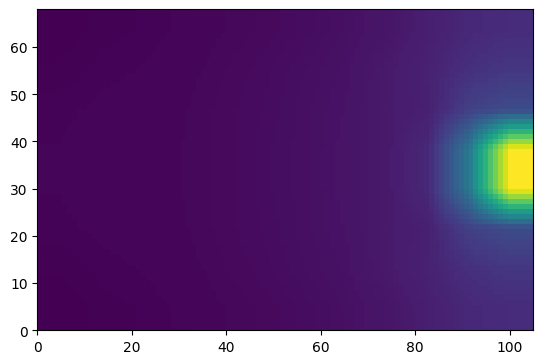

In [55]:
xT, xgrid, ygrid =  generate_expected_threat_surface(1)
xmin = np.amin(xgrid)
xmax = np.amax(xgrid)
plt.imshow(np.flipud(xT), extent=(xmin, xmax, np.amin(ygrid), np.amax(ygrid)),alpha=1)

In [56]:
def generate_off_ball_scoring_opportunity_for_frame(frame, tracking_home, tracking_away, attacking_team, params, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    
    where_home_attacks = pc.where_home_team_attacks(tracking_home)
    period=tracking_home.loc[frame]['Period']
    if attacking_team=='Home':
        if period==1:
            where_attack=where_home_attacks
        else:
            where_attack=-where_home_attacks
    else:
        if period==1:
            where_attack=-where_home_attacks
        else:
            where_attack=where_home_attacks
    
    xG, xgrid, ygrid = generate_expected_threat_surface(where_attack, field_dimen = field_dimen, n_grid_cells_x = n_grid_cells_x)
    rel_PPCF,xgrid,ygrid = viz.generate_relevant_pitch_for_frame(frame, tracking_home, tracking_away, attacking_team, params, field_dimen = field_dimen, n_grid_cells_x = n_grid_cells_x)
    
    return(xG*rel_PPCF,xgrid,ygrid)

In [149]:
def plot_scoring_opp_for_frame(frame, tracking_home, tracking_away, attacking_team, params, alpha = 0.7, include_player_velocities=True, annotate=True, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    
    #find attacking team    
    # plot frame and event
    fig,ax = viz.plot_pitch(field_color='white', field_dimen = field_dimen)
    viz.plot_frame( tracking_home.loc[frame], tracking_away.loc[frame], figax=(fig,ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate )
    
    #generate pitch control
    off_scoring, xgrid, ygrid = generate_off_ball_scoring_opportunity_for_frame(frame, tracking_home, tracking_away, attacking_team, params, field_dimen = field_dimen, n_grid_cells_x = n_grid_cells_x)

    # plot pitch control surface
    if attacking_team=='Home':
        cmap = 'Reds'
    else:
        cmap = 'Blues'
    print(off_scoring.shape)
    print(xgrid)
    print(ygrid.shape)
    ax.imshow(np.flipud(off_scoring), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=np.max(off_scoring),cmap=cmap)
    print('off ball expected threat: '+str(round(np.sum(off_scoring)*100,1))+ "%")
    
    return(fig,ax)
    

(32, 50)
[-53.         -50.83673469 -48.67346939 -46.51020408 -44.34693878
 -42.18367347 -40.02040816 -37.85714286 -35.69387755 -33.53061224
 -31.36734694 -29.20408163 -27.04081633 -24.87755102 -22.71428571
 -20.55102041 -18.3877551  -16.2244898  -14.06122449 -11.89795918
  -9.73469388  -7.57142857  -5.40816327  -3.24489796  -1.08163265
   1.08163265   3.24489796   5.40816327   7.57142857   9.73469388
  11.89795918  14.06122449  16.2244898   18.3877551   20.55102041
  22.71428571  24.87755102  27.04081633  29.20408163  31.36734694
  33.53061224  35.69387755  37.85714286  40.02040816  42.18367347
  44.34693878  46.51020408  48.67346939  50.83673469  53.        ]
(32,)
off ball expected threat: 1.4%


(<Figure size 1200x800 with 1 Axes>, <Axes: >)

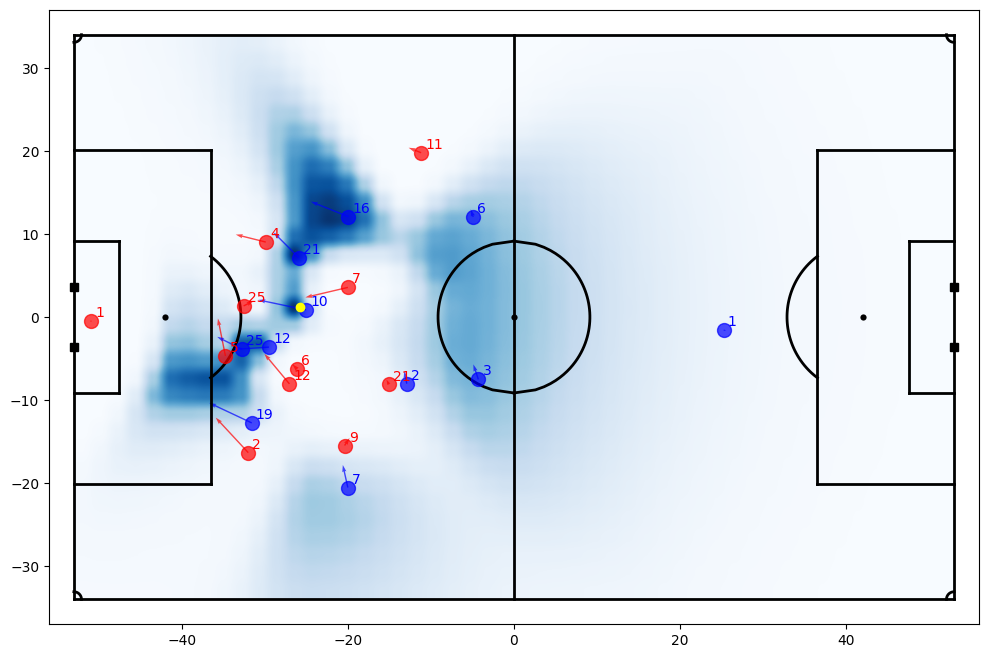

In [150]:
plot_scoring_opp_for_frame(frame, tracking_home, tracking_away, attacking_team, params)

In [26]:
off_scoring, xgrid, ygrid = generate_off_ball_scoring_opportunity_for_frame(frame, tracking_home, tracking_away, attacking_team, params)
str(round(np.sum(off_scoring)*100,1))

'1.7'

In [100]:
dataset = secondspectrum.load(
    meta_data="../man-city-data/SecondSpectrum/MCI Women_s Files-001/g2312135_SecondSpectrum_meta.xml",
    raw_data="../man-city-data/SecondSpectrum/MCI Women_s Files-001/g2312135_SecondSpectrum_tracking-produced.jsonl",
    
    # Optional arguments
    sample_rate=1/375,
    coordinates="secondspectrum",
    only_alive=True)

In [111]:
x.shape

(229, 120)

In [101]:
x = dataset.to_df()

In [104]:
x.iloc[0].period_id

1

In [105]:
frames = []
team = []
value = []
time = []
period = []
control_matrix_home_h1 = []
control_matrix_away_h1 = []
control_matrix_home_h2 = []
control_matrix_away_h2 = []
for index, row in x.iterrows():
    attacking_team = row["ball_owning_team_id"].capitalize()
    off_scoring, xgrid, ygrid = generate_off_ball_scoring_opportunity_for_frame(row["frame_id"], tracking_home, tracking_away, attacking_team, params)
    if row["period_id"] == 1:
        control_matrix_home_h1.append(off_scoring) if attacking_team == "Home" else control_matrix_away_h1.append(off_scoring) 
    else:
        control_matrix_home_h2.append(off_scoring) if attacking_team == "Home" else control_matrix_away_h2.append(off_scoring)
    frames.append(row["frame_id"])
    period.append(row["period_id"])
    team.append(attacking_team)
    value.append(round(np.sum(off_scoring)*100,1))
    time.append(row['timestamp'])

In [112]:
len(control_matrix_home_h1)+len(control_matrix_away_h1)+len(control_matrix_home_h2)+len(control_matrix_away_h2)

229

In [197]:
result = np.zeros(control_matrix_away_h1[0].shape)
for matrix in control_matrix_away_h2:
    result += matrix

In [198]:
field_dimen=(106.,68.)
n_grid_cells_y = int(50*field_dimen[1]/field_dimen[0])
xgrid = np.linspace( -field_dimen[0]/2., field_dimen[0]/2., 50)
ygrid = np.linspace( -field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y )

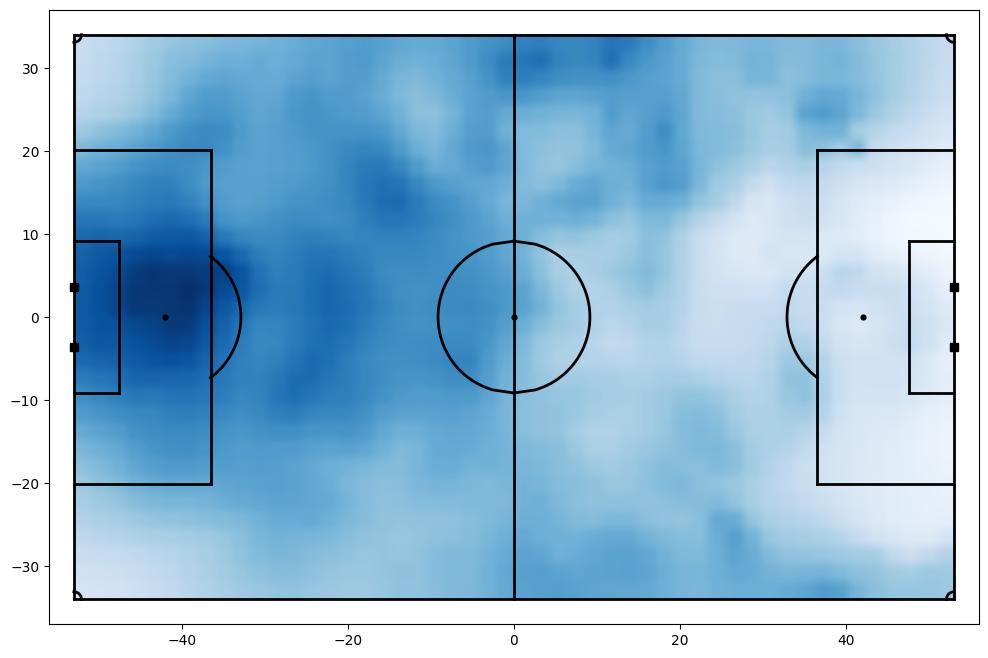

In [199]:
fig,ax = viz.plot_pitch(field_color='white', field_dimen = field_dimen)
ax.imshow(np.flipud(result), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=np.max(result),cmap="Blues")

In [97]:
x.iloc[0].frame_id

1

In [99]:
x["offballscore"] = x.apply(lambda row: round( np.sum(generate_off_ball_scoring_opportunity_for_frame(row.frame_id, tracking_home, tracking_away, attacking_team, params)[0]) * 100,1), axis =1)

KeyboardInterrupt: 

In [200]:
value_df = pd.DataFrame(
    {'frame': frames,
     'team': team,
     'time': time,
     'value': value,
     'period': period
    })

In [201]:
value_df.shape

(229, 5)

In [206]:
h2 = value_df[value_df.period == 2]

In [207]:
h2['xT'] = h2['value'] * h2['team'].apply(lambda x: 1 if x == 'Home' else -1)

In [40]:
for i in value_df.index:
    if i > 119:
        value_df.loc[i, 'time'] += 2700

In [208]:
h2.head()

,frame,team,time,value,period,xT
120,76885,Away,8.72,1.0,2,-1.0
121,77260,Away,23.72,1.4,2,-1.4
122,78131,Home,58.56,1.1,2,1.1
123,78506,Away,73.56,0.7,2,-0.7
124,79281,Away,104.56,0.9,2,-0.9


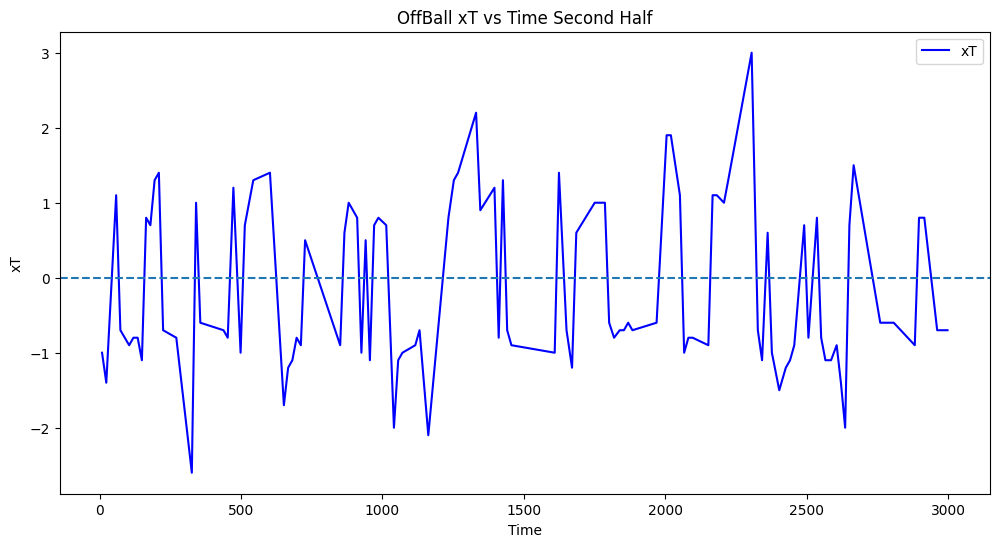

In [214]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create line chart with blue and red colors
h2.plot(x='time', y='xT', kind='line', color='blue', ax=ax)

# Add labels to the chart
plt.xlabel('Time')
plt.ylabel('xT')

# Add x-axis line at xT=0
ax.axhline(y=0, linestyle='--')

plt.title('OffBall xT vs Time Second Half')
plt.show()

In [60]:
frame = 60394
attacking_team = x.loc[x.frame_id == frame, "ball_owning_team_id"].item().capitalize()
attacking_team

'Away'

off ball expected threat: 2.0%


(<Figure size 1200x800 with 1 Axes>, <Axes: >)

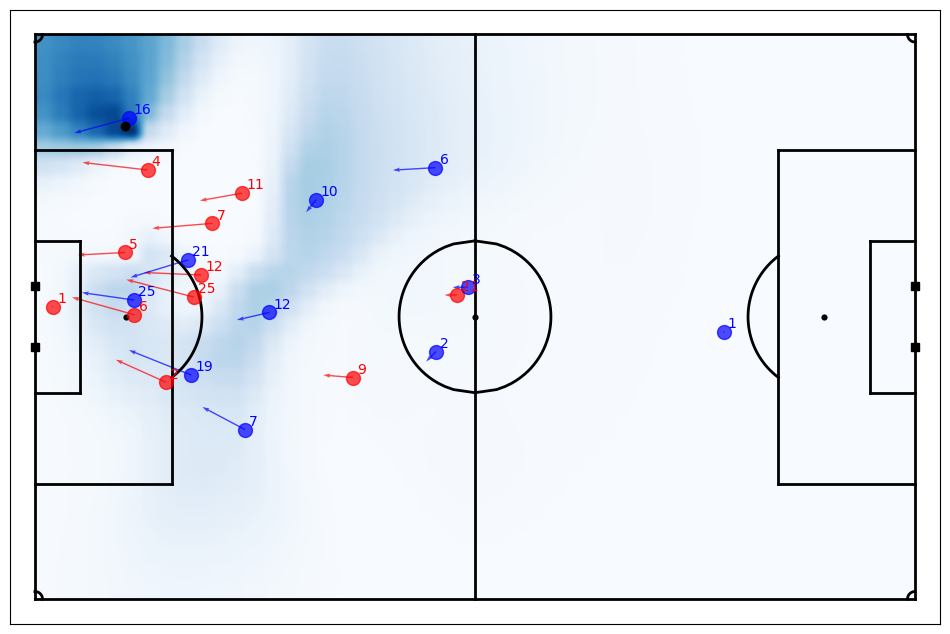

In [61]:
plot_scoring_opp_for_frame(frame, tracking_home, tracking_away, attacking_team, params)